# DQN Learning Rate Comparison

Comparison of training curves across three different learning rates:
- Run 01: learning_rate = 0.001
- Run 02: learning_rate = 0.0001
- Run 03: learning_rate = 0.01

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV files from the three runs
run01 = pd.read_csv('runs/run01/logs_lr_001.csv')
run02 = pd.read_csv('runs/run02/logs_lr_0001.csv')
run03 = pd.read_csv('runs/run03/logs_lr_01.csv')

print("Run 01 (LR=0.001):", run01.shape)
print("Run 02 (LR=0.0001):", run02.shape)
print("Run 03 (LR=0.01):", run03.shape)

Run 01 (LR=0.001): (800, 6)
Run 02 (LR=0.0001): (800, 6)
Run 03 (LR=0.01): (800, 6)


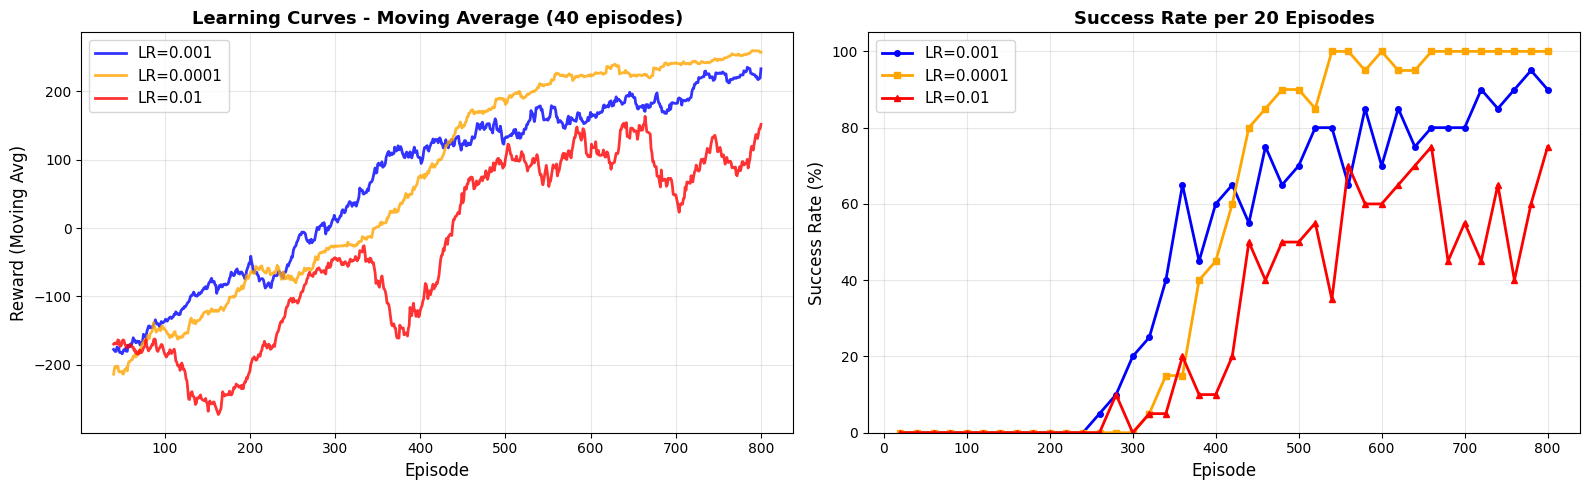

In [12]:
# Create comparison plot with moving averages
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Individual episode rewards with moving average
ax = axes[0]
window = 40
run01_ma = run01['reward'].rolling(window=window).mean()
run02_ma = run02['reward'].rolling(window=window).mean()
run03_ma = run03['reward'].rolling(window=window).mean()

ax.plot(run01['episode'], run01_ma, linewidth=2, label='LR=0.001', color='blue', alpha=0.8)
ax.plot(run02['episode'], run02_ma, linewidth=2, label='LR=0.0001', color='orange', alpha=0.8)
ax.plot(run03['episode'], run03_ma, linewidth=2, label='LR=0.01', color='red', alpha=0.8)
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Reward (Moving Avg)', fontsize=12)
ax.set_title(f'Learning Curves - Moving Average ({window} episodes)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Success rate (landed_success outcome)
ax = axes[1]
log_interval = 20
run01_success = run01.groupby((run01.index // log_interval))['outcome'].apply(lambda x: (x == 'landed_success').sum() / len(x) * 100)
run02_success = run02.groupby((run02.index // log_interval))['outcome'].apply(lambda x: (x == 'landed_success').sum() / len(x) * 100)
run03_success = run03.groupby((run03.index // log_interval))['outcome'].apply(lambda x: (x == 'landed_success').sum() / len(x) * 100)

episodes_bin = np.arange(1, len(run01_success) + 1) * log_interval

ax.plot(episodes_bin, run01_success, marker='o', linewidth=2, label='LR=0.001', color='blue', markersize=4)
ax.plot(episodes_bin, run02_success, marker='s', linewidth=2, label='LR=0.0001', color='orange', markersize=4)
ax.plot(episodes_bin, run03_success, marker='^', linewidth=2, label='LR=0.01', color='red', markersize=4)
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Success Rate (%)', fontsize=12)
ax.set_title(f'Success Rate per {log_interval} Episodes', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()